In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32919,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://10.6.129.37:43697,Total threads: 4
Dashboard: /proxy/35585/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:42169,


In [2]:
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

In [3]:
keys = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']

In [4]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

Load reanalysis and CMIP6 multimodel mean

In [5]:
uas = {}
vas = {}
uas['ERA-Interim'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA-Interim'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['ERA5'] = xr.open_dataset('../data/uas-era5-monthly-1979_2015.nc')['u10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA5'] = xr.open_dataset('../data/vas-era5-monthly-1979_2015.nc')['v10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50))
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50))
uas['JRA55'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['JRA55'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

Load CMIP6 individual models

In [6]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

In [50]:
del s_reanalysis

In [54]:
u_reanalysis = uas['ERA-Interim']
v_reanalysis = vas['ERA-Interim']
s_reanalysis = np.sqrt(uas['ERA-Interim']**2 + vas['ERA-Interim']**2)
for k in keys[1:-1]:
    u_reanalysis = xr.concat([uas[k], u_reanalysis], dim = 'product')
    v_reanalysis = xr.concat([vas[k], v_reanalysis], dim = 'product')
    s_reanalysis = xr.concat([np.sqrt(uas[k]**2 + vas[k]**2), s_reanalysis], dim = 'product')
    print(k)

ERA5
CFSR
JRA55


In [56]:
u_re_mean = u_reanalysis.mean('time').mean(dim = 'product')
v_re_mean = v_reanalysis.mean('time').mean(dim = 'product')
s_re_mean = s_reanalysis.mean('time').mean(dim = 'product')

In [57]:
s_cm_mean = np.sqrt(uas['CMIP6']**2 + vas['CMIP6']**2).mean('time')

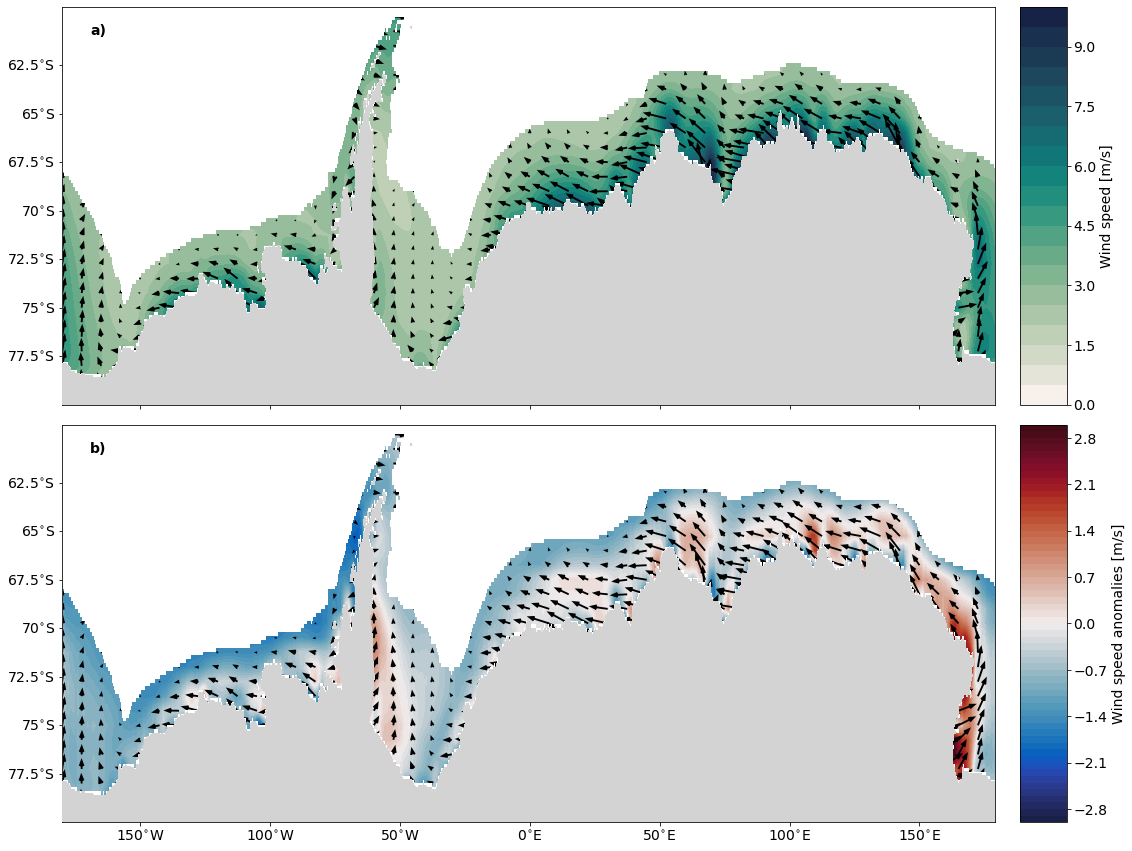

In [65]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 15))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .05], hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]), 
       fig.add_subplot(gr[1,1])]
for ax, label in zip(axs[:-2], ['a)', 'b)']):
    ax.text(0.03, .93, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax == axs[0]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, zorder = 3)
# Reanalysis
c = axs[0].contourf(s_re_mean['lon'], s_re_mean['lat'], s_re_mean, levels = np.arange(0, 10.5, .5), cmap = cmocean.cm.tempo, zorder = 0)
fig.colorbar(c, cax = axs[2]).set_label('Wind speed [m/s]')
axs[0].quiver(u_re_mean['lon'][::10].values, u_re_mean['lat'][::1].values, (u_re_mean[::1,::10]).values, (v_re_mean[::1,::10]).values, 
              scale = 250, width = 0.002, headlength = 4, zorder = 1)
axs[0].pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, cmap = 'binary', zorder = 2)
# CMIP6
c = axs[1].contourf(s_re_mean['lon'], s_re_mean['lat'], s_cm_mean-s_re_mean, levels = np.arange(-3, 3.1, .1), cmap = cmocean.cm.balance, zorder = 0)
fig.colorbar(c, cax = axs[3]).set_label('Wind speed anomalies [m/s]')
axs[1].quiver(uas['CMIP6']['lon'][::10].values, uas['CMIP6']['lat'][::1].values, 
             (uas['CMIP6'].mean('time')[::1,::10]).values, (vas['CMIP6'].mean('time')[::1,::10]).values, 
              scale = 250, width = 0.002, headlength = 4, zorder = 1)
axs[1].pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, cmap = 'binary', zorder = 2)
plt.savefig('../results/v3/fig1.jpg', bbox_inches = 'tight')

# Supplementary

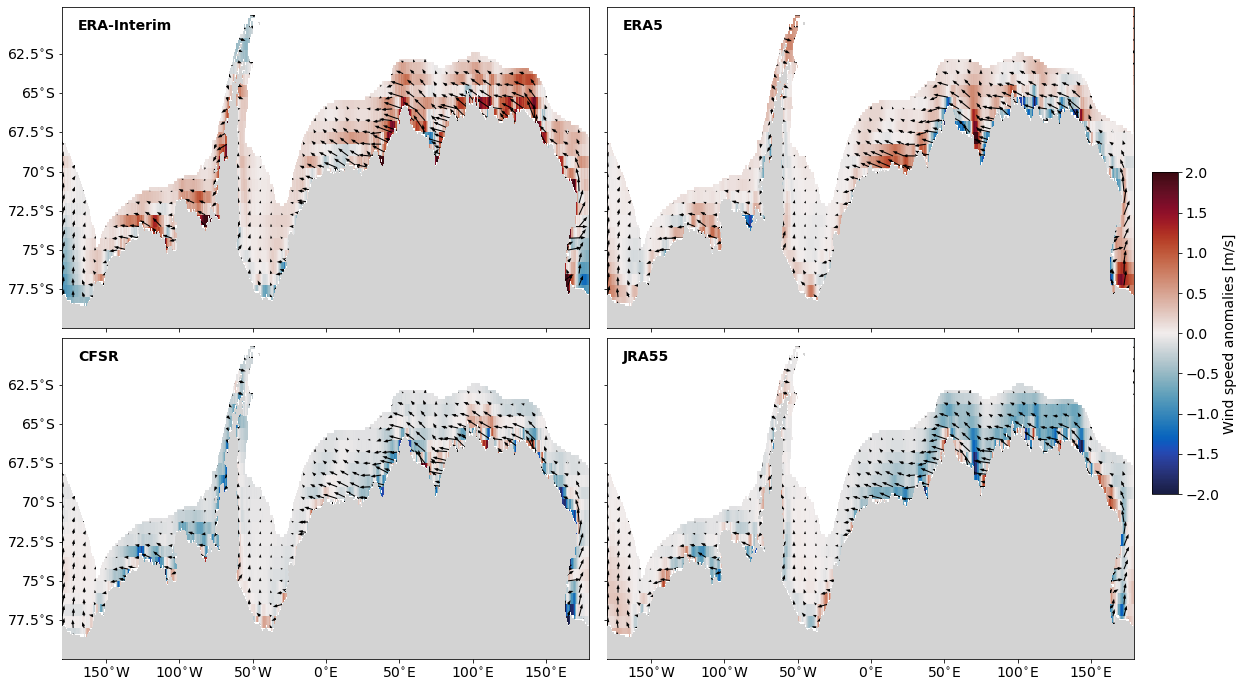

In [92]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20, 12))
gr = gs.GridSpec(4, 3, figure = fig, width_ratios = [1,1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[:2,0]),
       fig.add_subplot(gr[:2,1]),
       fig.add_subplot(gr[2:,0]), 
       fig.add_subplot(gr[2:,1]),
       fig.add_subplot(gr[1:3,2])]
for ax, label in zip(axs[:-1], keys):
    ax.text(0.03, .93, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    if ax in [axs[0], axs[2]]:
        ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, zorder = 3)
for n in range(0, 4):
    c = axs[n].pcolormesh(s_reanalysis['lon'], s_reanalysis['lat'], s_reanalysis.sel(product = n).mean('time')-s_re_mean, vmin = -2, vmax = 2,
                          cmap = cmocean.cm.balance)
    axs[n].quiver(u_reanalysis['lon'][::10].values, u_reanalysis['lat'][::1].values, (u_reanalysis.sel(product = n).mean('time')[::1,::10]).values, 
                  (v_reanalysis.sel(product = n).mean('time')[::1,::10]).values, scale = 230, width = 0.002, headlength = 4, zorder = 1)
    axs[n].pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, cmap = 'binary', zorder = 2)
fig.colorbar(c, cax = axs[-1]).set_label('Wind speed anomalies [m/s]')
plt.savefig('../results/v3/figsup1.jpg', bbox_inches = 'tight')

In [85]:
s_cmip6 = {}
for k in model_keys:
    s_cmip6[k] = np.sqrt(uas_cmip[k]**2+vas_cmip[k]**2).mean('time')-s_cm_mean

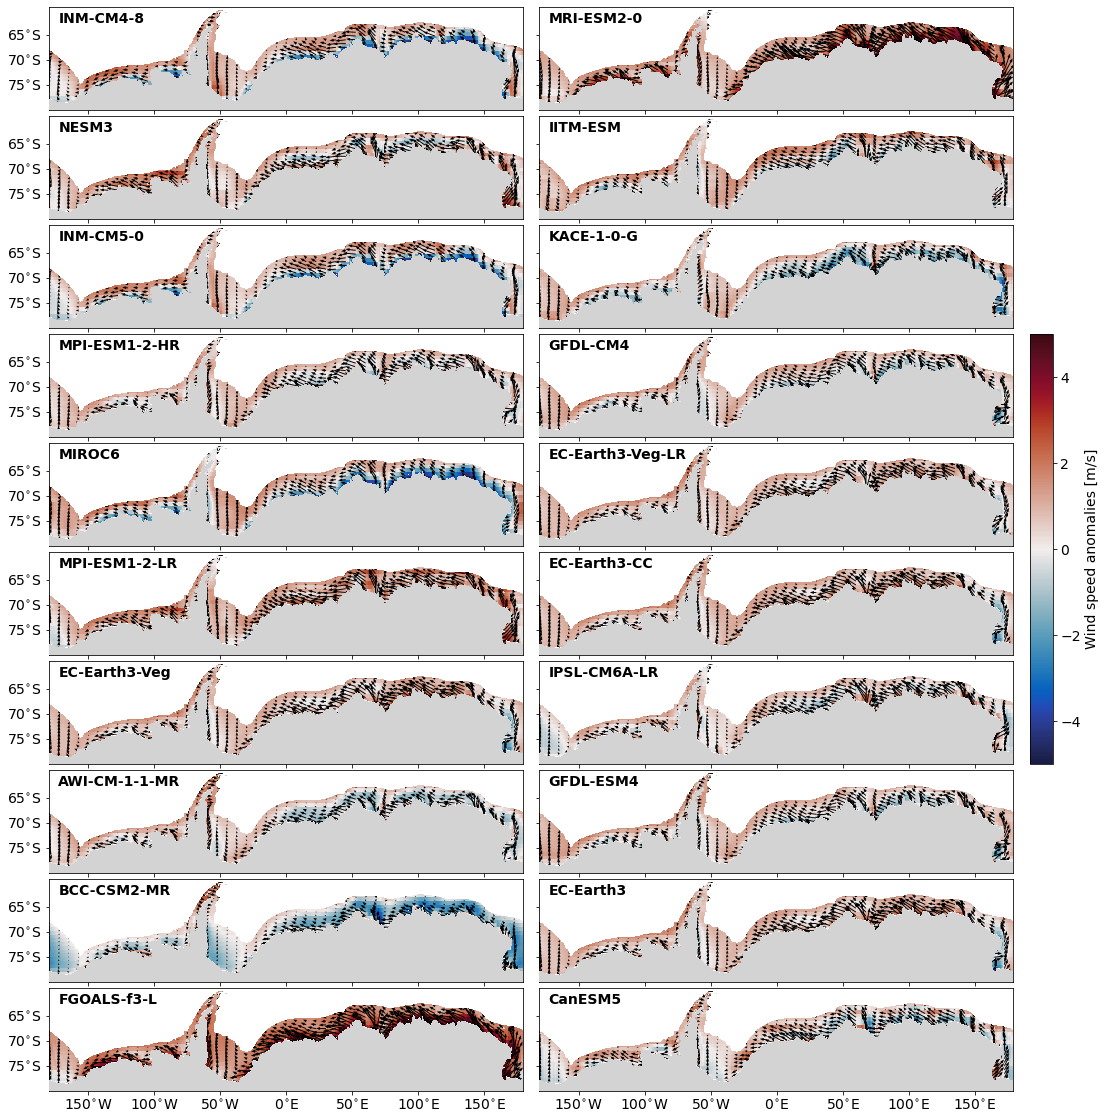

In [93]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 40))
gr = gs.GridSpec(20, 3, figure = fig, width_ratios = [1,1,.05], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0]), 
       fig.add_subplot(gr[9,1]),
       fig.add_subplot(gr[3:7,2])]
for ax, label in zip(axs[:-1], model_keys):
    ax.text(0.02, .85, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-75, -60,5))
    if ax in [axs[0], axs[2], axs[4], axs[6], axs[8], axs[10], axs[10], axs[12], axs[14], axs[16], axs[18], axs[20]]:
        ax.set_yticklabels(['75$^{\circ}$S', '70$^{\circ}$S', '65$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'lightgrey', linewidths = 0.5, zorder = 3)
n = 0
for k in model_keys:
    c = axs[n].pcolormesh(s_cmip6[k]['lon'], s_cmip6[k]['lat'], s_cmip6[k], vmin = -5, vmax = 5, cmap = cmocean.cm.balance)
    axs[n].quiver(s_cmip6[k]['lon'][::10].values, s_cmip6[k]['lat'][::1].values, (uas_cmip[k].mean('time')[::1,::10]).values, 
                  (vas_cmip[k].mean('time')[::1,::10]).values, scale = 230, width = 0.002, headlength = 4, zorder = 1)
    axs[n].pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, cmap = 'binary', zorder = 2)
    n += 1
fig.colorbar(c, cax = axs[-1]).set_label('Wind speed anomalies [m/s]')
plt.savefig('../results/v3/figsup2.jpg', bbox_inches = 'tight')